In [2]:
import os
from pathlib import Path
from typing import Iterable, Optional

import hydra
import numpy as np
import torch
import wandb
from accelerate import Accelerator
from matplotlib.cm import get_cmap
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from skimage.color import label2rgb
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import importlib

/home/guests/oleksandra_tmenova/test/project/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# evaluation utilities
import eval_utils
# for reading a dataset with groundth truth and labels
from dataset import EvalDataset


name="mutinfo_val_car_TEST"
# dataset_dir="/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/mutinfo_val_car_TEST"
dataset_dir = "/home/guests/oleksandra_tmenova/test/project/thesis-codebase/evaluation/demo_dataset"
n_classes=2
n_clusters=15
gt_dir=""
pred_dir=""
thresh=0.0




In [4]:
dataset = EvalDataset(dataset_dir,gt_dir, pred_dir)

root: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/evaluation/demo_dataset
image_dir: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/evaluation/demo_dataset/images
gt_dir: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/evaluation/demo_dataset/ground_truth
pred_dir: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/evaluation/demo_dataset/predictions
Checking sizes of ground truth and predictions


100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

unique labels per image: [0 1]
current_segm_num: 2
unique labels per image: [0 1 2]
current_segm_num: 3
self.n_clusters: 3


In [5]:
# Iterate
tp = [0] * n_classes
fp = [0] * n_classes
fn = [0] * n_classes

matches = []
iou_matrices = []
remapped_preds = []

In [6]:
image, gt, pred, metadata = dataset[1]

In [7]:
print(metadata['id'])

ultrasonix_test027


In [8]:
image_list = image.tolist()
print(image_list)

[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0

(-0.5, 387.5, 399.5, -0.5)

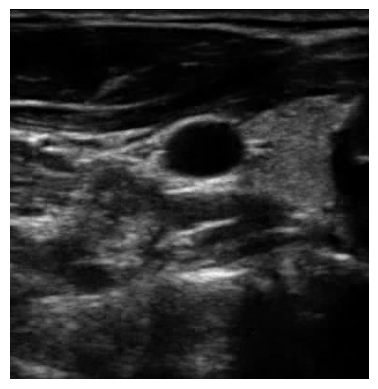

In [9]:
plt.imshow(image)
plt.axis(False)

(-0.5, 387.5, 399.5, -0.5)

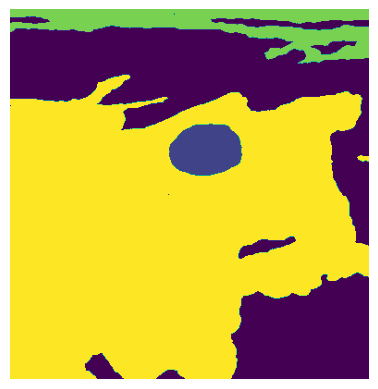

In [10]:
plt.imshow(gt)
plt.axis(False)

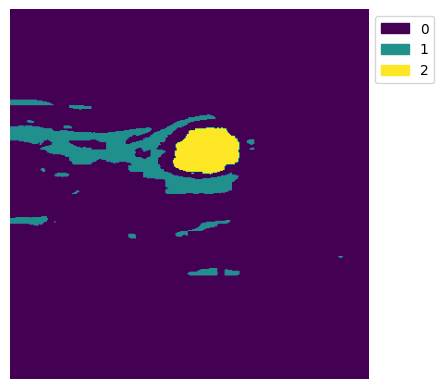

In [11]:
values = np.unique(pred.ravel())
im = plt.imshow(pred)
plt.axis(False)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=2)

# OLD MATCHING

In [14]:
# import eval_utils
importlib.reload(eval_utils)
# import eval_utils

# Do matching 
gt_unique = np.unique(gt)
pred_unique = np.unique(pred)
print(f'GT unique labels: {gt_unique}')
print(f'PRED unique labels: {pred_unique}')
if np.array_equal(gt_unique,pred_unique) and n_clusters==n_classes:
# if len(gt_unique)==len(pred_unique):
    print('Using hungarian algorithm for matching')
    match, iou_mat  = eval_utils.hungarian_match(pred, gt, preds_k=n_clusters, targets_k=n_classes, metric='iou', thresh=thresh)
else:
    print('Using majority voting for matching')
    match, iou_mat = eval_utils.majority_vote_unique(pred, gt, preds_k=n_clusters, targets_k=n_classes, thresh=thresh)
print(f'Optimal matching: {match}')

GT unique labels: [0 1]
PRED unique labels: [ 0  4  6  7 12]
Using majority voting for matching
No threshold used
Optimal matching: [(0, 0), (7, 1)]


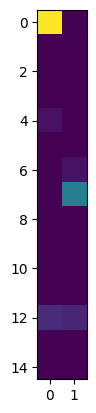

In [15]:
plt.imshow(iou_mat)

In [16]:
iou_mat.shape

(15, 2)

In [17]:
for gt in range(iou_mat.shape[0]):
    for pl in range(iou_mat.shape[1]):
        print(f'PL {pl}, GT {gt}: IoU value={iou_mat[gt][pl]}') 

PL 0, GT 0: IoU value=0.8399335717935615
PL 1, GT 0: IoU value=0.006074133704123824
PL 0, GT 1: IoU value=0.0
PL 1, GT 1: IoU value=0.0
PL 0, GT 2: IoU value=0.0
PL 1, GT 2: IoU value=0.0
PL 0, GT 3: IoU value=0.0
PL 1, GT 3: IoU value=0.0
PL 0, GT 4: IoU value=0.03910614525139665
PL 1, GT 4: IoU value=0.0
PL 0, GT 5: IoU value=0.0
PL 1, GT 5: IoU value=0.0
PL 0, GT 6: IoU value=0.004552376372525447
PL 1, GT 6: IoU value=0.039709649871904354
PL 0, GT 7: IoU value=0.005067781578613962
PL 1, GT 7: IoU value=0.3582842724978974
PL 0, GT 8: IoU value=0.0
PL 1, GT 8: IoU value=0.0
PL 0, GT 9: IoU value=0.0
PL 1, GT 9: IoU value=0.0
PL 0, GT 10: IoU value=0.0
PL 1, GT 10: IoU value=0.0
PL 0, GT 11: IoU value=0.0
PL 1, GT 11: IoU value=0.0
PL 0, GT 12: IoU value=0.10546509599987317
PL 1, GT 12: IoU value=0.0896670493685419
PL 0, GT 13: IoU value=0.0
PL 1, GT 13: IoU value=0.0
PL 0, GT 14: IoU value=0.0
PL 1, GT 14: IoU value=0.0


In [45]:
match

[(0, 0), (7, 1)]

# NEW MATCHING 

In [14]:
 # Remap to have consecutive labels
gt_remapped, gt_match = eval_utils.make_labels_consecutive(gt)
pred_remapped, pred_match = eval_utils.make_labels_consecutive(pred)

(-0.5, 387.5, 399.5, -0.5)

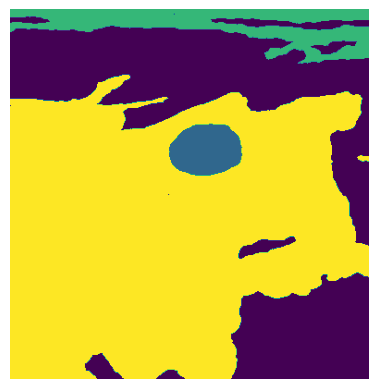

In [13]:
plt.imshow(gt_remapped)
plt.axis(False)

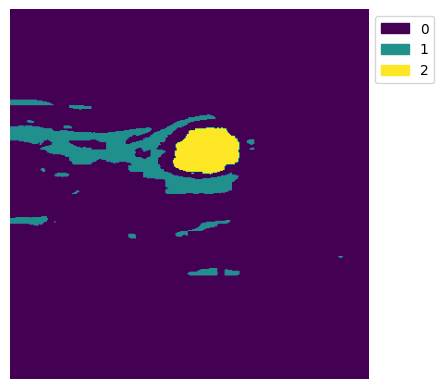

In [15]:
values = np.unique(pred_remapped.ravel())
im = plt.imshow(pred_remapped)
plt.axis(False)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=2)

In [1]:
importlib.reload(eval_utils)


NameError: name 'importlib' is not defined

In [51]:
match, iou  = eval_utils.match(pred_remapped, gt_remapped, thresh = 0.5)

GT unique labels: [0 1 2 3]
PRED unique labels: [0 1 2]
iou results_gt2pr:  [0 2 0 0]
iou results_pr2gt:  [3 3 1]
iou 1:  [[0.33450595 0.         0.        ]
 [0.00466368 0.         0.80454545]
 [0.07045359 0.         0.        ]
 [0.56054421 0.08247212 0.        ]]
iou 2:  [[0.33450595 0.00466368 0.07045359 0.56054421]
 [0.         0.         0.         0.08247212]
 [0.         0.80454545 0.         0.        ]]
Optimal matching: {0: 0, 1: 2, 2: 0, 3: 0}


In [18]:
iou

array([[0.33450595, 0.00466368, 0.07045359, 0.56054421],
       [0.        , 0.        , 0.        , 0.08247212],
       [0.        , 0.80454545, 0.        , 0.        ]])

In [49]:
# match2, iou2  = eval_utils.match(gt_remapped, pred_remapped, thresh = 0.0)


GT unique labels: [0 1 2 3 4]
PRED unique labels: [0 1]
n_clusters < n_classes: Using majority voting for matching
Optimal matching: [(0, 0), (1, 3)]


In [42]:
gt_match

[(0, 0), (1, 1)]

In [43]:
pred_match

[(0, 0), (4, 1), (6, 2), (7, 3), (12, 4)]

In [20]:
corrected_match = eval_utils.remap_match(match, gt_match, pred_match)

In [21]:
corrected_match

[(0, 5), (1, 0), (2, 1)]

In [50]:
# corrected_match2 = eval_utils.remap_match(match2, pred_match, gt_match)
# corrected_match2


[(0, 0), (1, 7)]

In [22]:
reordered_pred = eval_utils.remap_labels(pred, corrected_match)

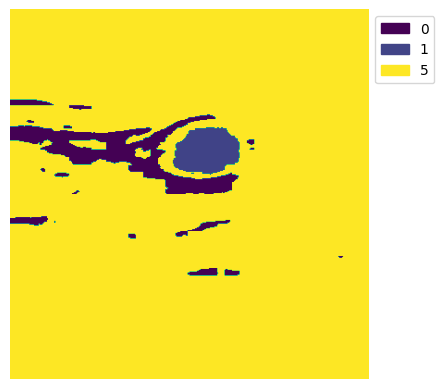

In [23]:
values = np.unique(reordered_pred.ravel())
im = plt.imshow(reordered_pred)
plt.axis(False)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=2)

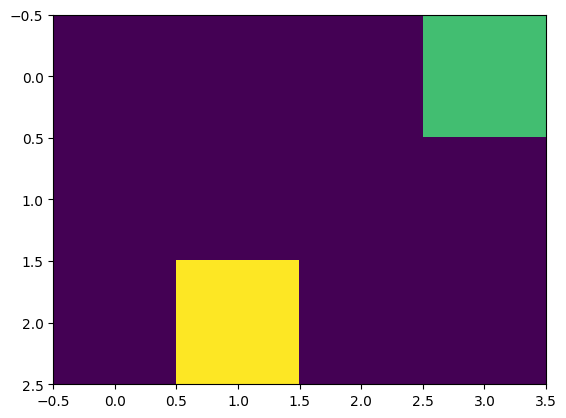

In [24]:
plt.imshow(iou)

In [55]:
import pandas as pd

In [25]:
# pseudolabel_names = [f'PL_class{label}' for label in np.unique(pred)]
# class_names = [f'GT_class{label}' for label in np.unique(gt)]


# # log IoU heatmaps - individually (cannot log wandb heatmaps in a wandb table...)
# iou_df = pd.DataFrame(data=iou2, index=pseudolabel_names, columns=class_names)
# heatmap = wandb.plots.HeatMap(class_names,pseudolabel_names, iou_df, show_text=True)

## Exclusive majority vote

In [20]:
importlib.reload(eval_utils)


<module 'eval_utils' from '/home/guests/oleksandra_tmenova/test/project/thesis-codebase/evaluation/eval_utils.py'>

In [21]:
match, iou  = eval_utils.match(pred_remapped, gt_remapped, thresh = 0.0)

GT unique labels: [0 1 2 3]
PRED unique labels: [0 1 2]
iou results_gt2pr:  [0 2 0 0]
iou results_pr2gt:  [3 3 1]
iou 1:  [[0.33450595 0.         0.        ]
 [0.00466368 0.         0.80454545]
 [0.07045359 0.         0.        ]
 [0.56054421 0.08247212 0.        ]]
iou 2:  [[0.33450595 0.00466368 0.07045359 0.56054421]
 [0.         0.         0.         0.08247212]
 [0.         0.80454545 0.         0.        ]]
match_gt2pr:  {0: -1, 1: 2, 2: -1, 3: 0}
match_pr2gt:  {0: 3, 1: -1, 2: 1}
Optimal matching: [(-1, 0), (2, 1), (-1, 2), (0, 3)]


In [35]:
match_gt_pr = {target_i: -1 for target_i in range(5)}
match_gt_pr

{0: -1, 1: -1, 2: -1, 3: -1, 4: -1}